# Applying GrandPrix on the cell cycle single cell nCounter data of PC3 human prostate cancer
_Sumon Ahmed_, 2017

This notebooks describes how GrandPrix with informative prior over the latent space can be used to infer the cell cycle stages from the single cell nCounter data of the PC3 human prostate cancer cell line.

In [33]:
import pandas as pd
import numpy as np
from GrandPrix import GrandPrix
from utils import plot_genes
%matplotlib inline

## Data decription
<a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4102402/" terget="_blank">McDavid et al. (2014)</a> assayed the expression profiles of the PC3 human prostate cancer cell line. They identified the cells in G0/G1, S and G2/M cell cycle stages. 

The cells identified as G0/G1, S and G2/M have been mapped to the capture times of 1, 2 and 3, respectively. Due to the additional challenge of optimizing pseudotime parameters for periodic data, random pseudotimes having the largest log likelihood to estimate cell cycle peak time points have been used to initilize the prior.


The "McDavidtrainingData.csv" file contains the expression profiles of the top 56 differentially expressed genes in 361 cells from the PC3 human prostate cancer cell line which have been used in the inference.

The "McDavidCellMeta.csv" file contains the additional information of the data such as capture time of each cells, different initializations of pseudotimes, etc.

In [34]:
Y = pd.read_csv('data/McDavid/McDavidtrainingData.csv', index_col=[0]).T
mData = pd.read_csv('data/McDavid/McDavidCellMeta.csv', index_col=[0])

In [35]:
N, D = Y.shape

In [36]:
mData.head()

,c,cell,captureStatus,cellline,plate,platerow,ngeneson,obstime,S.hat,capture,capture.orig,prior
1,1,10,PC33A,s,PC3,11,A,0.956522,2,0.099553,2,3.141667
2,2,10,PC33B,s,PC3,11,B,0.968379,2,0.104718,2,0.950000
3,3,10,PC33C,s,PC3,11,C,0.857708,2,0.089802,2,3.383333
4,4,10,PC33E,s,PC3,11,E,0.948617,2,0.104967,2,1.833333
5,5,10,PC33F,s,PC3,11,F,0.913043,2,0.110594,2,3.133333


## Model Construction
The first step of using the GrandPrix is to initialize the model with the observed data and the additional metadata (optional).

In [37]:
mp = GrandPrix(Y.values, mData)

### Build sparse Bayesian GPLVM model
Following initializations are essential for better optimizations. If not initialized, the default values will be used.  
<ul>
<li>__kernel:__ Covariance function to define the mappring mapping from the latent space to the data space in Gaussian process prior. 
<!--
    <ul>
        <li>name</li>
        <li>ls</li>
        <li>var</li>
        <li>period</li>
    </ul>
-->
</li>

<li>__vParams:__ Variational Parameters
    <ul>
        <li>Xmean - mean of the latent dimensions. 
        
        ndarray of size $N \times Q$.</li>
        <li>Xvar - variance over the latent dimensions. A single floating point value or a ndarray of size $N \times Q$.</li>
        <li>Z - inducing inputs. ndarray of size $M \times Q$.</li>
    </ul>
</li>
<li>__priors:__ Prior over the latent input dimensions
    <ul>
        <li>Priormean - mean of the prior distribution. ndarray of size $N \times D$.</li>
        <li>Priorvar - variance of the prior distribution. A floating point value or a ndarray of size $N \times D$.</li>
    </ul>
</li>

<li>__latent_dims:__ Number of latent dimensions. An integer.</li>
<li>__n_inducing_points:__ Number of inducing points. An integer.</li>
</ul>

In [49]:
np.random.seed(10)
sigma_t = .5
prior_mean = mData['prior'].values[:, None]

init_mean = mData['capture.orig'].values[:, None]
X_mean = [init_mean[i, 0] + sigma_t * np.random.randn(1) for i in range(0, N)]   

priors = {'Priormean':prior_mean, 'Priorvar':np.square(sigma_t)}
vParams = {'Xmean':np.asarray(X_mean)}

In [50]:
mp.build_model(priors, vParams, kernel={'name':'Periodic', 'ls':5.0}, n_inducing_points = 20)

### Run the model
- `fit_model` optimizes the model.
- `get_pseudotime` returns the estimated pseudotime points.

In [51]:
mp.fit_model()

In [52]:
pseudotimes = mp.get_pseudotime()

## Visualize the results
The expression profile of some interesting genes have been plotted against the estimated pseudotime. Each point corresponds to a particular gene expression in a cell. 

The points are coloured based on cell cycle stages according to <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4102402/" terget="_blank" style="text-decoration:none;">McDavid et al. (2014)</a>. The circular horizontal axis (where both first and last labels are G2/M) represents the periodicity realized by the method in pseudotime inference. 

The solid black line is the posterior predicted mean of expression profiles while the grey ribbon depicts the 95% confidence interval. 

The vertical dotted lines are the CycleBase peak times for the selected genes.

To see the expression profiles of a different set of genes a list containing gene names shound be passed to the function `plot_genes`.

In [53]:
selectedGenes = ['CDC6', 'MKI67', 'NUF2', 'PRR11', 'PTTG1', 'TPX2']

In [54]:
geneProfiles = pd.DataFrame({selectedGenes[i]: Y[selectedGenes[i]] for i in range(len(selectedGenes))})

- `predict_posterior` returns  the mean and variance of new data points.

In [55]:
Xnew = np.linspace(min(pseudotimes), max(pseudotimes), 100)[:, None]
mean, var = mp.predict_posterior(Xnew)

Binding gene names with predictive mean and variations

In [56]:
geneNames = Y.columns.values
name = [_ for _ in geneNames]
posterior_mean = pd.DataFrame(mean, columns=name)
posterior_var = pd.DataFrame(var, columns=name)

# geneData description
The "McDavidgene.csv" file contains gene specific information such as peak time, etc. for the top 56 differentially expressed genes. 

In [57]:
geneData = pd.read_csv('data/McDavid/McDavid_gene.csv', index_col=0).T


In [58]:
geneData.head()

gene,ABCF1,ALAS1,ANLN,ARL6IP1,ATF2,BCL6,BIRC5,BMP1,BTBD3,BUB1,...,UBE2C,UNG,USP1,VANGL1,VCAM1,VPS25,WDR76,ZC3HC1,ZNF367,ZRANB2
cbRank,NaN,NaN,90,16,NaN,NaN,38,NaN,207,15,...,8,252,136,194,NaN,262,171,25,48,187
cbPeaktime,NaN,NaN,89,91,NaN,NaN,94,NaN,97,92,...,81,39,56,98,NaN,71,47,91,39,40
expPeaktime,s,g2/m,g2/m,g2/m,g2/m,g0/g1,g2/m,s,s,g2/m,...,g2/m,g0/g1,s,g2/m,g2/m,g2/m,s,g2/m,s,g2/m
pvalue,2.26466,2.79702,37.9039,7.71864,0.382451,3.19427,6.87961,4.69341,12.1008,20.355,...,43.0782,24.2323,1.27999,4.02094,0.183032,4.39432,18.9298,5.63614,14.3334,0.657693


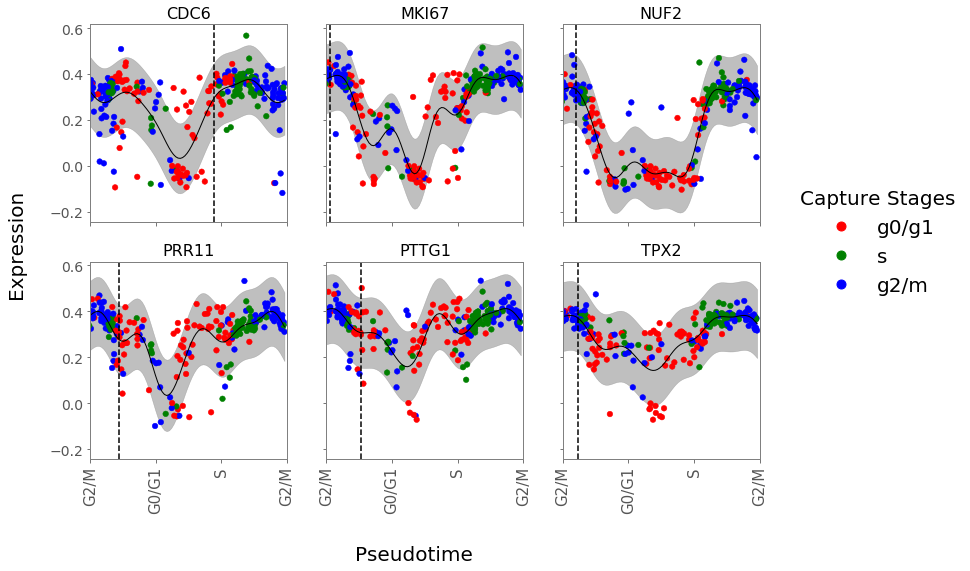

In [59]:
cpt = mData['capture.orig'].values
plot_genes(pseudotimes, geneProfiles, geneData, cpt, prediction=(Xnew, posterior_mean, posterior_var))